<a href="https://colab.research.google.com/github/ksahabir/nycschools-opendata/blob/main/changing_school_demographics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changing school demographics
=============================
This notebook creates a case study of how to use the NYC School data to look at questions of changing demographics and how that impacts other factors in schools.

- add a % change column to school demo that shows the 5 year change in each of the demographic field of poverty, with planned analysis including fields of fields of race/eth, ell and swd.
- map the schools with largest negative and postive change as a heat map
- calculate aggregates with this data by zip code and district




In [ ]:

!pip install nycschools
!pip install mapclassify

from nycschools import dataloader
dataloader.download_data()

In [ ]:

import pandas as pd
#from pandas.core.window.indexers import calculate_variable_window_bounds
import geopandas as gpd
import folium
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md
from IPython.display import display, HTML
from nycschools import schools, exams, ui, geo



In [ ]:
from nycschools import budgets

In [ ]:
df = schools.load_school_demographics()
change_cols = ['total_enrollment', 'asian_pct', 'black_pct',
       'hispanic_pct', 'white_pct', 'poverty_pct']
cols = ["dbn", "ay"] + change_cols
df = df[cols]
df = df.dropna()
df.head(20)



,dbn,ay,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,poverty_pct
0,01M015,2016,178,0.079,0.287,0.590,0.022,0.854
1,01M015,2017,190,0.105,0.274,0.579,0.032,0.847
2,01M015,2018,174,0.138,0.276,0.546,0.034,0.845
3,01M015,2019,190,0.142,0.295,0.505,0.047,0.816
4,01M015,2020,193,0.135,0.275,0.528,0.057,0.819
5,01M019,2016,271,0.089,0.188,0.664,0.055,0.764
6,01M019,2017,257,0.089,0.191,0.646,0.062,0.770
7,01M019,2018,249,0.056,0.209,0.627,0.072,0.735
8,01M019,2019,236,0.047,0.208,0.627,0.081,0.746
9,01M019,2020,212,0.061,0.193,0.613,0.080,0.712


In [ ]:
#df = df[df['ay']== 2016]

In [ ]:
df.describe()

,ay,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,poverty_pct
count,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000,10001.000000
mean,2018.025797,587.865913,0.115959,0.311174,0.424937,0.121446,0.764572
std,1.413695,468.705727,0.166804,0.263531,0.248044,0.175990,0.196051
min,2016.000000,7.000000,0.000000,0.000000,0.015000,0.000000,0.040000
25%,2017.000000,323.000000,0.015000,0.082000,0.201000,0.015000,0.706000
50%,2018.000000,478.000000,0.044000,0.248000,0.398000,0.035000,0.823000
75%,2019.000000,694.000000,0.143000,0.492000,0.629000,0.147000,0.903000
max,2020.000000,6040.000000,0.944000,0.963000,1.000000,0.945000,0.960000


In [ ]:
ay16 = df[df.ay == 2016].dbn
ay20 = df[df.ay == 2020].dbn

dbn_list = set(ay16).intersection(set(ay20))
data = df[df.dbn.isin(dbn_list)]
# data.ay.unique()

data_20 = data[data.ay == 2020]
data_16 = data[data.ay == 2016]

data_20.describe()


,ay,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,poverty_pct
count,1948.0,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000
mean,2020.0,577.143224,0.120104,0.299815,0.429953,0.120764,0.766379
std,0.0,464.935595,0.168653,0.256435,0.246689,0.169685,0.195644
min,2020.0,40.000000,0.000000,0.000000,0.015000,0.000000,0.050000
25%,2020.0,320.000000,0.015000,0.078000,0.206000,0.017000,0.711000
50%,2020.0,475.000000,0.048000,0.240500,0.402000,0.037000,0.828000
75%,2020.0,681.000000,0.155000,0.472000,0.628250,0.150250,0.903250
max,2020.0,5921.000000,0.926000,0.935000,1.000000,0.945000,0.960000


In [ ]:
data_20

,dbn,ay,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,poverty_pct
4,01M015,2020,193,0.135000,0.275000,0.528000,0.057000,0.819
9,01M019,2020,212,0.061000,0.193000,0.613000,0.080000,0.712
14,01M020,2020,412,0.248000,0.133000,0.522000,0.073000,0.709
19,01M034,2020,273,0.026000,0.381000,0.557000,0.029000,0.960
24,01M063,2020,208,0.029000,0.192000,0.635000,0.091000,0.769
...,...,...,...,...,...,...,...,...
9980,84X705,2020,416,0.007212,0.211538,0.776442,0.000000,0.960
9985,84X706,2020,647,0.000000,0.616692,0.358578,0.006182,0.832
9990,84X717,2020,328,0.012195,0.500000,0.478659,0.000000,0.878
9995,84X718,2020,570,0.008772,0.845614,0.100000,0.014035,0.819


In [ ]:
data_20.dtypes

dbn                  object
ay                    int64
total_enrollment      int64
asian_pct           float64
black_pct           float64
hispanic_pct        float64
white_pct           float64
poverty_pct         float64
dtype: object

In [ ]:
def calc_diff(row_20):
    row_16 = data[(data.dbn == row_20.dbn) & (data.ay == 2016)].iloc[0]
    
    for c in change_cols:
          row_20[f"{c}_change"] = row_20[c] - row_16[c]
          row_20[f"{c}_pct_change"] = row_20[f"{c}_pct_change"] = ((row_20[c] + 1) - (row_16[c] + 1)) / (row_16[c] + 1)
    return row_20
    

x = data_20.apply(calc_diff, axis=1)
x.head()

,dbn,ay,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,poverty_pct,total_enrollment_change,total_enrollment_pct_change,asian_pct_change,asian_pct_pct_change,black_pct_change,black_pct_pct_change,hispanic_pct_change,hispanic_pct_pct_change,white_pct_change,white_pct_pct_change,poverty_pct_change,poverty_pct_pct_change
4,01M015,2020,193,0.135,0.275,0.528,0.057,0.819,15,0.083799,0.056,0.051900,-0.012,-0.009324,-0.062,-0.038994,0.035,0.034247,-0.035,-0.018878
9,01M019,2020,212,0.061,0.193,0.613,0.080,0.712,-59,-0.216912,-0.028,-0.025712,0.005,0.004209,-0.051,-0.030649,0.025,0.023697,-0.052,-0.029478
14,01M020,2020,412,0.248,0.133,0.522,0.073,0.709,-128,-0.236599,-0.076,-0.057402,0.037,0.033759,0.033,0.022163,0.023,0.021905,0.126,0.079596
19,01M034,2020,273,0.026,0.381,0.557,0.029,0.960,-77,-0.219373,-0.028,-0.026565,0.090,0.069713,-0.060,-0.037106,-0.002,-0.001940,0.000,0.000000
24,01M063,2020,208,0.029,0.192,0.635,0.091,0.769,8,0.039801,-0.011,-0.010577,0.007,0.005907,-0.010,-0.006079,-0.014,-0.012670,-0.056,-0.030685


In [ ]:
x.describe()

,ay,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,poverty_pct,total_enrollment_change,total_enrollment_pct_change,asian_pct_change,asian_pct_pct_change,black_pct_change,black_pct_pct_change,hispanic_pct_change,hispanic_pct_pct_change,white_pct_change,white_pct_pct_change,poverty_pct_change,poverty_pct_pct_change
count,1948.0,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000,1948.000000
mean,2020.0,577.143224,0.120104,0.299815,0.429953,0.120764,0.766379,-29.614476,0.008166,0.006130,0.005736,-0.021630,-0.014247,0.012338,0.009968,-0.002380,-0.000330,0.033806,0.022026
std,0.0,464.935595,0.168653,0.256435,0.246689,0.169685,0.195644,137.006145,0.642267,0.035462,0.028748,0.050239,0.034621,0.049135,0.035485,0.040694,0.032288,0.096185,0.059628
min,2020.0,40.000000,0.000000,0.000000,0.015000,0.000000,0.050000,-576.000000,-0.693146,-0.246000,-0.169421,-0.377000,-0.221634,-0.242000,-0.156432,-0.303000,-0.199868,-0.325000,-0.192446
25%,2020.0,320.000000,0.015000,0.078000,0.206000,0.017000,0.711000,-103.000000,-0.190476,-0.007000,-0.005941,-0.044000,-0.031340,-0.015000,-0.010850,-0.014000,-0.012419,-0.025000,-0.014026
50%,2020.0,475.000000,0.048000,0.240500,0.402000,0.037000,0.828000,-29.500000,-0.063864,0.003000,0.002935,-0.013000,-0.010905,0.011000,0.008130,0.000000,0.000000,0.016000,0.009155
75%,2020.0,681.000000,0.155000,0.472000,0.628250,0.150250,0.903250,25.000000,0.048596,0.018000,0.016915,0.004000,0.003965,0.039000,0.028950,0.011000,0.010832,0.085000,0.051905
max,2020.0,5921.000000,0.926000,0.935000,1.000000,0.945000,0.960000,780.000000,21.882353,0.183000,0.129883,0.262000,0.184898,0.252000,0.184345,0.301000,0.272892,0.457000,0.311328


In [ ]:
x.corrwith(x['poverty_pct_pct_change'])

ay                                  NaN
total_enrollment               0.019982
asian_pct                      0.059128
black_pct                     -0.071423
hispanic_pct                   0.057824
white_pct                     -0.018068
poverty_pct                    0.115047
total_enrollment_change       -0.095445
total_enrollment_pct_change   -0.095356
asian_pct_change               0.012661
asian_pct_pct_change           0.015816
black_pct_change               0.106954
black_pct_pct_change           0.103226
hispanic_pct_change            0.087634
hispanic_pct_pct_change        0.078659
white_pct_change              -0.209200
white_pct_pct_change          -0.216601
poverty_pct_change             0.993704
poverty_pct_pct_change         1.000000
dtype: float64

In [ ]:
#categorizes school by quartile of poverty percent change percent

x['poverty_pct_change_quartile'] = pd.qcut(x['poverty_pct_pct_change'], q = 4, labels = [4,3,2,1])

In [ ]:
x.corrwith(x['poverty_pct_change_quartile'])

ay                                  NaN
total_enrollment               0.002590
asian_pct                      0.002561
black_pct                      0.049295
hispanic_pct                  -0.055330
white_pct                     -0.006310
poverty_pct                   -0.078938
total_enrollment_change        0.089932
total_enrollment_pct_change    0.072773
asian_pct_change              -0.068926
asian_pct_pct_change          -0.067123
black_pct_change              -0.070868
black_pct_pct_change          -0.068389
hispanic_pct_change           -0.068695
hispanic_pct_pct_change       -0.059423
white_pct_change               0.193554
white_pct_pct_change           0.191917
poverty_pct_change            -0.878747
poverty_pct_pct_change        -0.864151
dtype: float64

In [ ]:
# make a map of the schools plotted by change in income
school_loc = geo.load_school_locations()
school_loc.describe()

,district,x,y,administrative_district_code,borough_block_lot,census_tract,community_district,community_district_1,council_district,fiscal_year,geographical_district_code,latitude,longitude,police_precinct
count,2104.000000,2.104000e+03,2104.000000,2009.000000,2.008000e+03,2008.000000,2008.000000,2008.000000,2008.000000,2009.0,2009.000000,2009.000000,2009.000000,2003.000000
mean,28.423004,1.006079e+06,207317.605513,27.191140,2.652432e+09,36461.497022,271.777888,271.777888,24.285857,2020.0,15.574415,40.735970,-73.920925,64.917124
std,27.195472,2.173388e+04,30966.535443,26.403329,1.180209e+09,34292.183350,113.384388,113.384388,14.617221,0.0,9.315014,0.085233,0.078217,33.217025
min,1.000000,9.164130e+05,124552.000000,1.000000,0.000000e+00,13.000000,101.000000,101.000000,1.000000,2020.0,1.000000,40.508300,-74.243950,1.000000
25%,10.000000,9.935625e+05,184303.000000,10.000000,2.026058e+09,13100.000000,203.000000,203.000000,12.000000,2020.0,8.000000,40.672290,-73.965862,42.000000
50%,20.000000,1.005780e+06,204533.000000,19.000000,3.012930e+09,25100.000000,303.000000,303.000000,23.000000,2020.0,15.000000,40.729052,-73.921631,67.000000
75%,30.000000,1.017263e+06,236547.500000,30.000000,3.083438e+09,46201.000000,318.000000,318.000000,37.000000,2020.0,24.000000,40.816158,-73.881187,92.000000
max,93.000000,1.065003e+06,268380.000000,84.000000,5.078980e+09,162100.000000,503.000000,503.000000,51.000000,2020.0,32.000000,40.903275,-73.708617,123.000000


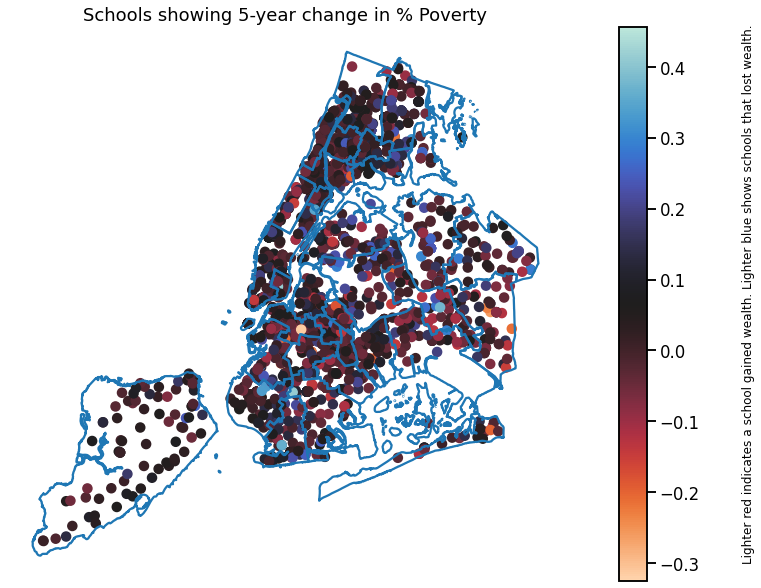

In [ ]:

districts = geo.load_districts()

# merge poverty_pct_change into our location dataframe
school_loc = school_loc.merge(x[["dbn", "poverty_pct_change"]], on="dbn", how="inner")

# get the plot
fig, ax = plt.subplots(figsize=(16, 16))
sns.set_context('talk')
plt.axis('off')


# map the district outlines
districts.boundary.plot(ax=ax)
# map a colored point for each school
# pick a color: https://matplotlib.org/stable/tutorials/colors/colormaps.html
school_loc.plot(ax=ax, column="poverty_pct_change", cmap="icefire_r", legend=True)

ax.set_title('Schools showing 5-year change in % Poverty',)
fig.suptitle('Lighter red indicates a school gained wealth. Lighter blue shows schools that lost wealth.', fontsize=12, x =.95, y=.5, rotation=90)
fig.tight_layout()

In [ ]:
school_loc

,dbn,zip,geo_district,district,x,y,administrative_district_code,administrative_district_name,beds,borough_block_lot,...,open_date,police_precinct,primary_building_code,principal_name,principal_phone_number,principal_title,state_code,status_descriptions,geometry,poverty_pct_change
0,02M212,10036,2,2,987390,216649,2.0,COMMUNITY SCHOOL DISTRICT 02,310200010212,1.010380e+09,...,1999-07-01,18.0,M017,KATHLEEN LOUA,212-247-0208,Principal,NY,Open,POINT (-73.98867 40.76133),0.049
1,29Q034,11429,29,29,1056968,198417,29.0,COMMUNITY SCHOOL DISTRICT 29,342900010034,4.111510e+09,...,1898-07-01,105.0,Q034,PAULINE SHAKESPEARE,718-465-6818,Principal,NY,Open,POINT (-73.73770 40.71099),-0.039
2,17K091,11203,17,17,1000700,180396,17.0,COMMUNITY SCHOOL DISTRICT 17,331700010091,3.047940e+09,...,1904-07-01,71.0,K091,Tessa Alleyne,718-756-0243,Principal,NY,Open,POINT (-73.94071 40.66181),-0.007
3,31R455,10312,31,31,930477,131756,31.0,COMMUNITY SCHOOL DISTRICT 31,353100011455,5.066130e+09,...,1972-07-01,123.0,R455,Joseph Scarmato,718-668-8800,Principal,NY,Open,POINT (-74.19343 40.52815),0.099
4,07X522,10451,7,7,1006407,237542,7.0,NaN,320700011522,2.024110e+09,...,2011-07-01,40.0,X600,JOYCE PULPHUS,718-402-7690,Principal,NY,Open,POINT (-73.91995 40.81865),0.037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2581,15K124,11215,15,15,986852,182452,15.0,COMMUNITY SCHOOL DISTRICT 15,331500010124,3.010340e+09,...,1900-07-01,78.0,K124,Maria Interlandi,718-788-0246,I.A. Principal,NY,Open,POINT (-73.99062 40.66746),0.151
2582,28Q161,11419,28,28,1033868,190873,28.0,COMMUNITY SCHOOL DISTRICT 28,342800010161,4.094910e+09,...,2000-07-01,102.0,Q161,JILL HODER,718-441-5493,Principal,NY,Open,POINT (-73.82108 40.69044),-0.117
2583,08X100,10473,8,8,1022234,238985,8.0,COMMUNITY SCHOOL DISTRICT 08,320800010100,2.036410e+09,...,1961-07-01,43.0,X100,ARIANA ARBOLINO,718-842-1461,Principal,NY,Open,POINT (-73.86276 40.82255),0.119
2584,84M523,10024,3,84,991316,225688,84.0,OFFICE OF CHARTER SCHOOLS,310300861008,1.012150e+09,...,2011-07-01,20.0,M470,Jennifer Haynes,646-274-1580,Principal,NY,Open,POINT (-73.97448 40.78613),0.176


In [ ]:
#plot for change in pct_change over 5 year

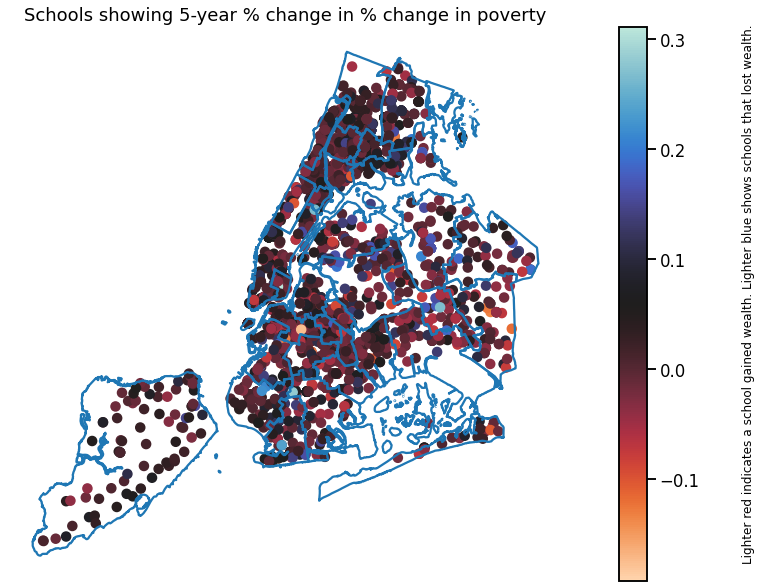

In [ ]:
# make a map of the schools plotted by change in income
school_loc = geo.load_school_locations()
districts = geo.load_districts()

# merge poverty_pct_pct_change into our location dataframe
school_loc = school_loc.merge(x[["dbn", "poverty_pct_pct_change"]], on="dbn", how="inner")

# get the plot
fig, ax = plt.subplots(figsize=(16, 16))
sns.set_context('talk')
plt.axis('off')


# map the district outlines
districts.boundary.plot(ax=ax)
# map a colored point for each school
# pick a color: https://matplotlib.org/stable/tutorials/colors/colormaps.html
school_loc.plot(ax=ax, column="poverty_pct_pct_change", cmap="icefire_r", legend=True)

ax.set_title('Schools showing 5-year % change in % change in poverty',)
fig.suptitle('Lighter red indicates a school gained wealth. Lighter blue shows schools that lost wealth.', fontsize=12, x =.95, y=.5, rotation=90)
fig.tight_layout()

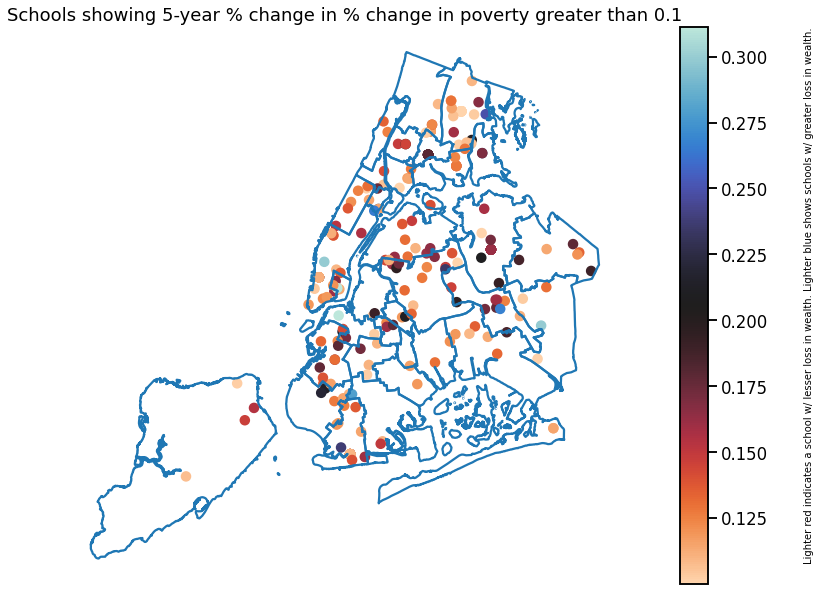

In [ ]:
school_loc_high = school_loc.loc[school_loc['poverty_pct_pct_change'] > 0.1]

# get the plot
fig, ax = plt.subplots(figsize=(16, 16))
sns.set_context('talk')
plt.axis('off')


# map the district outlines
districts.boundary.plot(ax=ax)
# map a colored point for each school
# pick a color: https://matplotlib.org/stable/tutorials/colors/colormaps.html
school_loc_high.plot(ax=ax, column="poverty_pct_pct_change", cmap="icefire_r", legend=True)

ax.set_title('Schools showing 5-year % change in % change in poverty greater than 0.1',)
fig.suptitle('Lighter red indicates a school w/ lesser loss in wealth. Lighter blue shows schools w/ greater loss in wealth.', fontsize=10, x =.95, y=.5, rotation=90)
fig.tight_layout()

In [ ]:
school_loc_high['poverty_pct_pct_change'].describe()

count    302.000000
mean       0.142880
std        0.039453
min        0.100060
25%        0.111176
50%        0.131316
75%        0.161889
max        0.311328
Name: poverty_pct_pct_change, dtype: float64

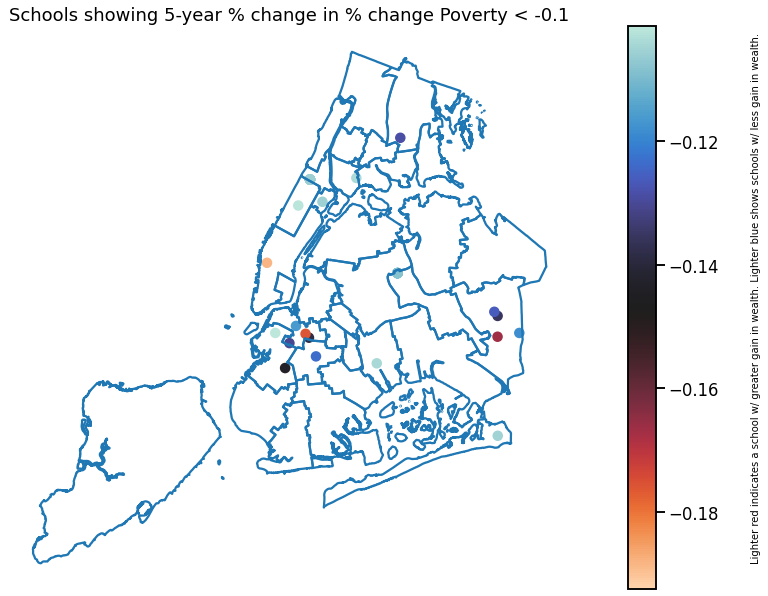

In [ ]:
school_loc_low = school_loc.loc[school_loc['poverty_pct_pct_change'] < -0.1]

# get the plot
fig, ax = plt.subplots(figsize=(16, 16))
sns.set_context('talk')
plt.axis('off')


# map the district outlines
districts.boundary.plot(ax=ax)
# map a colored point for each school
# pick a color: https://matplotlib.org/stable/tutorials/colors/colormaps.html
school_loc_low.plot(ax=ax, column="poverty_pct_pct_change", cmap="icefire_r", legend=True)

ax.set_title('Schools showing 5-year % change in % change Poverty < -0.1',)
fig.suptitle('Lighter red indicates a school w/ greater gain in wealth. Lighter blue shows schools w/ less gain in wealth.', fontsize=10, x =.95, y=.5, rotation=90)
fig.tight_layout()

In [ ]:
school_loc_low['poverty_pct_pct_change'].describe()

count    51.000000
mean     -0.116237
std       0.021420
min      -0.192446
25%      -0.112174
50%      -0.108182
75%      -0.105806
max      -0.101343
Name: poverty_pct_pct_change, dtype: float64